In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Define the path to the directory containing the spectrogram images
spectrogram_dir = '10sec_augmented_spectrogram_images'

# Define the model hyperparameters
input_shape = (64, 64, 3)  
num_classes = len(os.listdir(spectrogram_dir))  


# Load spectrogram images and labels
spectrograms = []
labels = []

for genre_folder in os.listdir(spectrogram_dir):
    genre_dir = os.path.join(spectrogram_dir, genre_folder)
    for filename in os.listdir(genre_dir):
        if filename.endswith('.png'):
            filepath = os.path.join(genre_dir, filename)
            spectrogram = tf.keras.preprocessing.image.load_img(filepath, target_size=(input_shape[0], input_shape[1]))
            spectrogram = tf.keras.preprocessing.image.img_to_array(spectrogram)
            spectrogram /= 255.0  # Normalize pixel values to [0, 1]
            spectrograms.append(spectrogram)
            labels.append(genre_folder)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Sort the data by labels
sorting_indices = np.argsort(labels_encoded)
spectrograms = np.array(spectrograms)[sorting_indices]
labels_encoded = labels_encoded[sorting_indices]

num_classes = len(label_encoder.classes_)
labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

# Split the data into training and testing sets
X_train_spectrogram, X_test_spectrogram, y_train_spectrogram, y_test_spectrogram = train_test_split(spectrograms, labels_one_hot, test_size=0.2, random_state=42)

joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [3]:
data = pd.read_csv('gtzan_features_with_augmentation_10sec_segments.csv')

X = data.drop(['filename', 'label'], axis=1)
y = data['label']
X = X.values
y = y.values

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()
y=to_categorical(label_encoder.fit_transform(y))


X_train_feature, X_test_feature, y_train_feature, y_test_feature = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train_feature = scaler.fit_transform(X_train_feature)
X_test_feature = scaler.transform(X_test_feature)

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [4]:
y_train_feature.shape

(9571, 10)

In [5]:
y_train_spectrogram.shape

(9571, 10)

In [6]:
y_test_feature

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
y_test_spectrogram

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Get predictions from the base models on the validation set
feature_model1 = load_model('ann_feature_10sec_model.h5')  
feature_model2 = load_model('cnn_feature_10sec_model.h5')  

spectrogram_model1 = load_model('CNN_spectrogram_10sec_model.h5')  
spectrogram_model2 = load_model('GRU_spectrogram_10sec_model.h5') 
spectrogram_model3 = load_model('LSTM_spectrogram_10sec_model.h5')


feature_model1_prediction = feature_model1.predict(X_test_feature)
feature_model2_prediction = feature_model2.predict(X_test_feature)
spectrogram_model1_prediction = spectrogram_model1.predict(X_test_spectrogram)
spectrogram_model2_prediction = spectrogram_model2.predict(X_test_spectrogram)
spectrogram_model3_prediction = spectrogram_model3.predict(X_test_spectrogram)

# Average the predictions as input features for the meta-model
X_meta_train = (feature_model1_prediction + feature_model2_prediction + spectrogram_model1_prediction + spectrogram_model2_prediction + spectrogram_model3_prediction) / 5.0



# Define the meta-model architecture
meta_model = models.Sequential()
meta_model.add(layers.Dense(1024, activation='relu', input_shape=(X_meta_train.shape[1],)))
meta_model.add(layers.Dropout(0.2))

meta_model.add(layers.Dense(512, activation='relu'))
meta_model.add(layers.Dropout(0.2))

meta_model.add(layers.Dense(256, activation='relu'))
meta_model.add(layers.Dropout(0.2))
meta_model.add(layers.Dense(10, activation='softmax'))

meta_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the meta-model on the combined predictions
model_checkpoint = ModelCheckpoint('ensemble_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
history = meta_model.fit(X_meta_train, y_test_spectrogram, epochs=10, batch_size=32, validation_split=0.2, callbacks=[model_checkpoint])


75/75 [==============================] - 5s 60ms/step
Epoch 1/10
60/60 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.9127
Epoch 1: val_accuracy improved from -inf to 0.97912, saving model to ensemble_averaging_model.h5
60/60 [==============================] - 3s 30ms/step - loss: 0.4910 - accuracy: 0.9127 - val_loss: 0.0502 - val_accuracy: 0.9791
Epoch 2/10
 4/60 [=>............................] - ETA: 1s - loss: 0.0591 - accuracy: 0.9766

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/60 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9752
Epoch 2: val_accuracy improved from 0.97912 to 0.98121, saving model to ensemble_averaging_model.h5
60/60 [==============================] - 1s 25ms/step - loss: 0.0857 - accuracy: 0.9754 - val_loss: 0.0547 - val_accuracy: 0.9812
Epoch 3/10
59/60 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9825
Epoch 3: val_accuracy did not improve from 0.98121
60/60 [==============================] - 2s 27ms/step - loss: 0.0611 - accuracy: 0.9828 - val_loss: 0.0695 - val_accuracy: 0.9770
Epoch 4/10
57/60 [===========================>..] - ETA: 0s - loss: 0.0553 - accuracy: 0.9808
Epoch 4: val_accuracy did not improve from 0.98121
60/60 [==============================] - 1s 20ms/step - loss: 0.0533 - accuracy: 0.9817 - val_loss: 0.0544 - val_accuracy: 0.9729
Epoch 5/10
57/60 [===========================>..] - ETA: 0s - loss: 0.0526 - accuracy: 0.9852
Epoch 5: val_accuracy did not improve from 

In [18]:
# Evaluate the best model
test_loss, test_acc = meta_model.evaluate(X_meta_train, y_test_spectrogram)
print(f'Test accuracy: {test_acc * 100:.2f}%')
print(f"Test_Loss: {test_loss:.4f}")

75/75 [==============================] - 0s 4ms/step - loss: 0.0462 - accuracy: 0.9850
Test accuracy: 98.50%
Test_Loss: 0.0462


75/75 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       247
   classical       0.99      0.99      0.99       234
     country       0.99      0.99      0.99       236
       disco       0.99      0.98      0.99       252
      hiphop       0.99      0.97      0.98       247
        jazz       1.00      0.99      1.00       229
       metal       0.99      1.00      1.00       247
         pop       0.98      1.00      0.99       251
      reggae       0.98      0.99      0.99       218
        rock       0.97      0.97      0.97       232

    accuracy                           0.99      2393
   macro avg       0.99      0.99      0.99      2393
weighted avg       0.99      0.99      0.99      2393



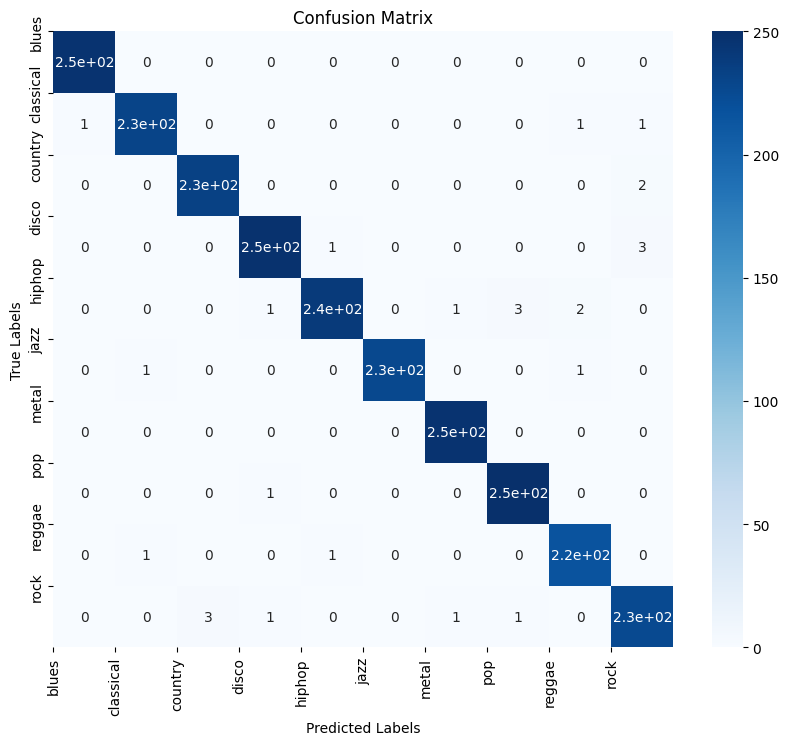

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def model_evaluation_report(model):

  # Evaluate the model on the test data
  y_pred = model.predict(X_meta_train)
  y_pred_classes = np.argmax(y_pred, axis=1)

  # Inverse transform encoded labels to original labels
  y_test_original = label_encoder.inverse_transform(y_test_spectrogram.argmax(axis=1))
  y_pred_original = label_encoder.inverse_transform(y_pred_classes)

  # Print classification report
  print(classification_report(y_test_original, y_pred_original))

  # Plot the confusion matrix
  conf_matrix = confusion_matrix(y_test_original, y_pred_original)
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, cmap='Blues',  annot=True)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=90)
  plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
  plt.show()


# Load the saved model
model = tf.keras.models.load_model('ensemble_averaging_model.h5')
model_evaluation_report(model)

In [11]:
# Evaluate the models on the test data
feature_model1_loss, feature_model1_acc = feature_model1.evaluate(X_test_feature, y_test_feature, verbose=0)
feature_model2_loss, feature_model2_acc = feature_model2.evaluate(X_test_feature, y_test_feature, verbose=0)
spectrogram_model1_loss, spectrogram_model1_acc = spectrogram_model1.evaluate(X_test_spectrogram, y_test_spectrogram, verbose=0)
spectrogram_model2_loss, spectrogram_model2_acc = spectrogram_model2.evaluate(X_test_spectrogram, y_test_spectrogram, verbose=0)
spectrogram_model3_loss, spectrogram_model3_acc = spectrogram_model3.evaluate(X_test_spectrogram, y_test_spectrogram, verbose=0)
ensemble_model_loss, ensemble_model_acc = meta_model.evaluate(X_meta_train, y_test_spectrogram, verbose=0)

# Print the evaluation results for each model
print("\nEvaluation Results:")

# Feature Model 1
print("\nFeature Model 1:")
print(f"Accuracy: {feature_model1_acc * 100:.2f}%, Loss: {feature_model1_loss:.4f}")

# Feature Model 2
print("\nFeature Model 2:")
print(f"Accuracy: {feature_model2_acc * 100:.2f}%, Loss: {feature_model2_loss:.4f}")

# Spectrogram Model 1
print("\nSpectrogram Model 1:")
print(f"Accuracy: {spectrogram_model1_acc * 100:.2f}%, Loss: {spectrogram_model1_loss:.4f}")

# Spectrogram Model 2
print("\nSpectrogram Model 2:")
print(f"Accuracy: {spectrogram_model2_acc * 100:.2f}%, Loss: {spectrogram_model2_loss:.4f}")

# Spectrogram Model 3
print("\nSpectrogram Model 3:")
print(f"Accuracy: {spectrogram_model3_acc * 100:.2f}%, Loss: {spectrogram_model3_loss:.4f}")

# Ensemble Model
print("\nEnsemble Model:")
print(f"Accuracy: {ensemble_model_acc * 100:.2f}%, Loss: {ensemble_model_loss:.4f}")



Evaluation Results:

Feature Model 1:
Accuracy: 93.48%, Loss: 0.2450

Feature Model 2:
Accuracy: 91.10%, Loss: 0.3401

Spectrogram Model 1:
Accuracy: 91.56%, Loss: 0.2710

Spectrogram Model 2:
Accuracy: 90.18%, Loss: 0.3335

Spectrogram Model 3:
Accuracy: 89.76%, Loss: 0.3270

Ensemble Model:
Accuracy: 98.54%, Loss: 0.0490


In [ ]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
from collections import Counter
tf.keras.utils.disable_interactive_logging()

from collections import Counter

def test_music_genre(audio_file):
    # Define the function to extract features from audio
    def extract_features_segment(audio_data, sr):
        chroma_stft_mean = np.mean(librosa.feature.chroma_stft(y=audio_data, sr=sr))
        chroma_stft_var = np.var(librosa.feature.chroma_stft(y=audio_data, sr=sr))
        rms_mean = np.mean(librosa.feature.rms(y=audio_data))
        rms_var = np.var(librosa.feature.rms(y=audio_data))
        spectral_centroid_mean = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sr))
        spectral_centroid_var = np.var(librosa.feature.spectral_centroid(y=audio_data, sr=sr))
        spectral_bandwidth_mean = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sr))
        spectral_bandwidth_var = np.var(librosa.feature.spectral_bandwidth(y=audio_data, sr=sr))
        rolloff_mean = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sr))
        rolloff_var = np.var(librosa.feature.spectral_rolloff(y=audio_data, sr=sr))
        zero_crossing_rate_mean = np.mean(librosa.feature.zero_crossing_rate(audio_data))
        zero_crossing_rate_var = np.var(librosa.feature.zero_crossing_rate(audio_data))
        harmony_mean = np.mean(librosa.effects.harmonic(y=audio_data))
        harmony_var = np.var(librosa.effects.harmonic(y=audio_data))
        perceptr_mean = np.mean(librosa.effects.percussive(y=audio_data))
        perceptr_var = np.var(librosa.effects.percussive(y=audio_data))
        tempo, _ = librosa.beat.beat_track(y=audio_data, sr=sr)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=20)
        mfcc_means = np.mean(mfccs, axis=1)
        mfcc_vars = np.var(mfccs, axis=1)

        # Combine the extracted features into a single array
        return [chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spectral_centroid_mean,
                spectral_centroid_var, spectral_bandwidth_mean, spectral_bandwidth_var, rolloff_mean,
                rolloff_var, zero_crossing_rate_mean, zero_crossing_rate_var, harmony_mean, harmony_var,
                perceptr_mean, perceptr_var, tempo] + list(mfcc_means) + list(mfcc_vars)

    # Define the function to create spectrogram from audio
    def create_spectrogram(audio_data, sr, temp_dir, input_shape):
        plt.figure(figsize=(3, 3))
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
        plt.axis('off')

        # Use the provided temporary directory
        spectrogram_filename = os.path.join(temp_dir, 'spectrogram.png')
        plt.savefig(spectrogram_filename, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close()

        return spectrogram_filename

    # Load the saved models
    feature_model1 = load_model('ann_feature_10sec_model.h5')  
    feature_model2 = load_model('cnn_feature_10sec_model.h5')  

    spectrogram_model1 = load_model('CNN_spectrogram_10sec_model.h5')  
    spectrogram_model2 = load_model('GRU_spectrogram_10sec_model.h5') 
    spectrogram_model3 = load_model('LSTM_spectrogram_10sec_model.h5')

    # Load the scaler and label encoder for feature-based models
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')

    # Define a function to preprocess input for feature-based models
    def preprocess_features(audio_data, sr):
        features = extract_features_segment(audio_data, sr)
        features_scaled = scaler.transform(np.array([features]))
        return features_scaled

    # Define a function to preprocess input for spectrogram-based models
    def preprocess_spectrogram(audio_data, sr):
        input_shape = (64, 64, 3)  # Assuming input shape for spectrogram models
        with tempfile.TemporaryDirectory() as temp_dir:
            spectrogram_filename = create_spectrogram(audio_data, sr, temp_dir, input_shape)
            spectrogram = tf.keras.preprocessing.image.load_img(spectrogram_filename, target_size=(input_shape[0], input_shape[1]))
            spectrogram = tf.keras.preprocessing.image.img_to_array(spectrogram)
            spectrogram /= 255.0  # Normalize pixel values to [0, 1]
            spectrogram = np.expand_dims(spectrogram, axis=0)
        return spectrogram


    # Load the audio file
    audio_data, sr = librosa.load(audio_file)

    # Define segment duration (10 seconds)
    segment_duration = 10 * sr

    # Calculate the number of segments
    num_segments = len(audio_data) // segment_duration

    # Define lists to store predictions for each model
    feature_model1_predictions = []
    feature_model2_predictions = []
    spectrogram_model1_predictions = []
    spectrogram_model2_predictions = []
    spectrogram_model3_predictions = []
    ensemble_predictions = []

    # Iterate over each segment
    for segment_index in range(num_segments):
        start_sample = segment_index * segment_duration
        end_sample = (segment_index + 1) * segment_duration
        segment_audio = audio_data[start_sample:end_sample]

        # Predictions for each individual model
        features_input = preprocess_features(segment_audio, sr)
        spectrogram_input = preprocess_spectrogram(segment_audio, sr)

        feature_model1_prediction = feature_model1.predict(features_input.reshape(1, features_input.shape[1],))
        feature_model2_prediction = feature_model2.predict(features_input.reshape(1, features_input.shape[1],1))
        spectrogram_model1_prediction = spectrogram_model1.predict(spectrogram_input)
        spectrogram_model2_prediction = spectrogram_model2.predict(spectrogram_input)
        spectrogram_model3_prediction = spectrogram_model3.predict(spectrogram_input)

        # Append predictions to respective lists
        feature_model1_predictions.append(label_encoder.inverse_transform([np.argmax(feature_model1_prediction)])[0])
        feature_model2_predictions.append(label_encoder.inverse_transform([np.argmax(feature_model2_prediction)])[0])
        spectrogram_model1_predictions.append(label_encoder.inverse_transform([np.argmax(spectrogram_model1_prediction)])[0])
        spectrogram_model2_predictions.append(label_encoder.inverse_transform([np.argmax(spectrogram_model2_prediction)])[0])
        spectrogram_model3_predictions.append(label_encoder.inverse_transform([np.argmax(spectrogram_model3_prediction)])[0])

        # Average the predictions as input features for the meta-model
        X_meta_test = (feature_model1_prediction + feature_model2_prediction + spectrogram_model1_prediction + spectrogram_model2_prediction + spectrogram_model3_prediction) / 5.0

        # Load the meta-model (stacked ensemble model)
        meta_model = load_model('ensemble_model.h5')

        # Predict with the meta-model (stacked ensemble)
        ensemble_prediction = meta_model.predict(X_meta_test)
        ensemble_prediction = label_encoder.inverse_transform([np.argmax(ensemble_prediction)])[0]

        # Append the predicted label to the ensemble predictions list
        ensemble_predictions.append(ensemble_prediction)

        # # Print predictions for each segment for each individual model
        # print(f"Segment {segment_index + 1} Predictions:")
        # print("Feature Model 1 Prediction:", label_encoder.inverse_transform([np.argmax(feature_model1_prediction)])[0])
        # print("Feature Model 2 Prediction:", label_encoder.inverse_transform([np.argmax(feature_model2_prediction)])[0])
        # print("Spectrogram Model 1 Prediction:", label_encoder.inverse_transform([np.argmax(spectrogram_model1_prediction)])[0])
        # print("Spectrogram Model 2 Prediction:", label_encoder.inverse_transform([np.argmax(spectrogram_model2_prediction)])[0])
        # print("Spectrogram Model 3 Prediction:", label_encoder.inverse_transform([np.argmax(spectrogram_model3_prediction)])[0])

        # # Print ensemble prediction
        # print("Ensemble Prediction:", ensemble_prediction)
        # print()

    # Convert predictions to tuples for Counter
    feature_model1_predictions = tuple(feature_model1_predictions)
    feature_model2_predictions = tuple(feature_model2_predictions)
    spectrogram_model1_predictions = tuple(spectrogram_model1_predictions)
    spectrogram_model2_predictions = tuple(spectrogram_model2_predictions)
    spectrogram_model3_predictions = tuple(spectrogram_model3_predictions)
    ensemble_predictions = tuple(ensemble_predictions)

    # Find the most common predictions for each model
    most_common_feature_model1 = Counter(feature_model1_predictions).most_common(1)[0][0]
    most_common_feature_model2 = Counter(feature_model2_predictions).most_common(1)[0][0]
    most_common_spectrogram_model1 = Counter(spectrogram_model1_predictions).most_common(1)[0][0]
    most_common_spectrogram_model2 = Counter(spectrogram_model2_predictions).most_common(1)[0][0]
    most_common_spectrogram_model3 = Counter(spectrogram_model3_predictions).most_common(1)[0][0]
    most_common_ensemble = Counter(ensemble_predictions).most_common(1)[0][0]

    print("Most Common feature_model1 Prediction:", most_common_feature_model1)
    print("Most Common feature_model2 Prediction:", most_common_feature_model2)
    print("Most Common spectrogram_model1 Prediction:", most_common_spectrogram_model1)
    print("Most Common spectrogram_model2 Prediction:", most_common_spectrogram_model2)
    print("Most Common spectrogram_model3 Prediction:", most_common_spectrogram_model3)
    print("Most Common ensemble_model Prediction:", most_common_ensemble)


In [ ]:
def test_music_genre_folder(folder_path):
    # List all files in the folder
    audio_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.wav', '.mp3', '.FLAC'))]

    # Perform genre classification for each audio file
    for audio_file in audio_files:
        print(f"Audio File: {os.path.basename(audio_file)}")
        print("-" * 50)
        test_music_genre(audio_file)
        print("=" * 50)
        print()



## Blues

In [ ]:
folder_path = "Final Music_audios_for_testing/Blues"

test_music_genre_folder(folder_path)

Audio File: 07. Terraplane Blues (Remastered).mp3
--------------------------------------------------
Most Common feature_model1 Prediction: jazz
Most Common feature_model2 Prediction: country
Most Common spectrogram_model1 Prediction: blues
Most Common spectrogram_model2 Prediction: blues
Most Common spectrogram_model3 Prediction: blues
Most Common ensemble_model Prediction: blues

Audio File: 05. When You Got A Good Friend (Remastered).mp3
--------------------------------------------------
Most Common feature_model1 Prediction: blues
Most Common feature_model2 Prediction: country
Most Common spectrogram_model1 Prediction: blues
Most Common spectrogram_model2 Prediction: blues
Most Common spectrogram_model3 Prediction: blues
Most Common ensemble_model Prediction: blues

Audio File: 01. Kind Hearted Woman Blues (Remastered).mp3
--------------------------------------------------
Most Common feature_model1 Prediction: jazz
Most Common feature_model2 Prediction: jazz
Most Common spectrogra

## Classical

In [ ]:
folder_path = "Music_audios_for_testing/Classical"

test_music_genre_folder(folder_path)

Audio File: 02 AMidsummer Night's Dream, Dance of the Clowns.wav
--------------------------------------------------
Most Common feature_model1 Prediction: classical
Most Common feature_model2 Prediction: classical
Most Common spectrogram_model1 Prediction: classical
Most Common spectrogram_model2 Prediction: classical
Most Common spectrogram_model3 Prediction: classical
Most Common ensemble_model Prediction: classical

Audio File: 07 Swan Lake, Tanz der Schwane.wav
--------------------------------------------------
Most Common feature_model1 Prediction: classical
Most Common feature_model2 Prediction: classical
Most Common spectrogram_model1 Prediction: classical
Most Common spectrogram_model2 Prediction: jazz
Most Common spectrogram_model3 Prediction: classical
Most Common ensemble_model Prediction: classical

Audio File: 05 Spring Song.wav
--------------------------------------------------
Most Common feature_model1 Prediction: classical
Most Common feature_model2 Prediction: classic

##Country

In [ ]:
folder_path = "Music_audios_for_testing/Country"

test_music_genre_folder(folder_path)

Audio File: 01 - Skeeter Davis (Mary Frances Penick) - Desperado (unknown Cover The eagles 1973).FLAC
--------------------------------------------------
Most Common feature_model1 Prediction: country
Most Common feature_model2 Prediction: country
Most Common spectrogram_model1 Prediction: country
Most Common spectrogram_model2 Prediction: country
Most Common spectrogram_model3 Prediction: country
Most Common ensemble_model Prediction: country

Audio File: 02 - Lynn Andersen - Rose garden (1970 Cover Joe South 1969).FLAC
--------------------------------------------------
Most Common feature_model1 Prediction: rock
Most Common feature_model2 Prediction: disco
Most Common spectrogram_model1 Prediction: country
Most Common spectrogram_model2 Prediction: country
Most Common spectrogram_model3 Prediction: country
Most Common ensemble_model Prediction: country

Audio File: 03 - Willie Nelson - Pretty paper (1979 Cover Roy Orbison 1963).FLAC
--------------------------------------------------
M

##Disco

In [ ]:
folder_path = "Music_audios_for_testing/Disco"

test_music_genre_folder(folder_path)

Audio File: 01. Sister Sledge - He's the Greatest Dancer.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: hiphop
Most Common feature_model2 Prediction: hiphop
Most Common spectrogram_model1 Prediction: disco
Most Common spectrogram_model2 Prediction: disco
Most Common spectrogram_model3 Prediction: disco
Most Common ensemble_model Prediction: disco

Audio File: 02. Chic - Le Freak.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: pop
Most Common feature_model2 Prediction: disco
Most Common spectrogram_model1 Prediction: disco
Most Common spectrogram_model2 Prediction: disco
Most Common spectrogram_model3 Prediction: disco
Most Common ensemble_model Prediction: disco

Audio File: 03. Curtis Mayfield - Move on Up.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: disco
Most Common feature_model2 Prediction: blues
Most Common spectrogram_model1 Prediction: di

##Hiphop

In [ ]:
folder_path = "Music_audios_for_testing/Hiphop"

test_music_genre_folder(folder_path)

Audio File: 04. N.Y. State Of Mind.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: hiphop
Most Common feature_model2 Prediction: hiphop
Most Common spectrogram_model1 Prediction: rock
Most Common spectrogram_model2 Prediction: rock
Most Common spectrogram_model3 Prediction: rock
Most Common ensemble_model Prediction: rock

Audio File: 06. Mama Said Knock You Out.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: hiphop
Most Common feature_model2 Prediction: hiphop
Most Common spectrogram_model1 Prediction: hiphop
Most Common spectrogram_model2 Prediction: hiphop
Most Common spectrogram_model3 Prediction: hiphop
Most Common ensemble_model Prediction: hiphop

Audio File: 02. C.R.E.A.M..mp3
--------------------------------------------------
Most Common feature_model1 Prediction: reggae
Most Common feature_model2 Prediction: reggae
Most Common spectrogram_model1 Prediction: reggae
Most Common spectrogr

##Jazz

In [ ]:
folder_path = "Music_audios_for_testing/Jazz"

test_music_genre_folder(folder_path)

Audio File: 01. Bill Evans - Autumn Leaves.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: jazz
Most Common feature_model2 Prediction: jazz
Most Common spectrogram_model1 Prediction: jazz
Most Common spectrogram_model2 Prediction: jazz
Most Common spectrogram_model3 Prediction: jazz
Most Common ensemble_model Prediction: jazz

Audio File: 02. Cannonball Adderley - Mercy, Mercy, Mercy.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: rock
Most Common feature_model2 Prediction: jazz
Most Common spectrogram_model1 Prediction: jazz
Most Common spectrogram_model2 Prediction: jazz
Most Common spectrogram_model3 Prediction: jazz
Most Common ensemble_model Prediction: jazz

Audio File: 03. Herbie Hancock - Cantaloupe Island.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: jazz
Most Common feature_model2 Prediction: jazz
Most Common spectrogram_model1 Prediction

##Metal

In [ ]:
folder_path = "Music_audios_for_testing/Metal"

test_music_genre_folder(folder_path)

Audio File: 001. Slipknot - Duality.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: hiphop
Most Common feature_model2 Prediction: metal
Most Common spectrogram_model1 Prediction: metal
Most Common spectrogram_model2 Prediction: metal
Most Common spectrogram_model3 Prediction: metal
Most Common ensemble_model Prediction: metal

Audio File: 002. Iron Maiden - Run to the Hills (2015 Remaster).mp3
--------------------------------------------------
Most Common feature_model1 Prediction: rock
Most Common feature_model2 Prediction: blues
Most Common spectrogram_model1 Prediction: metal
Most Common spectrogram_model2 Prediction: metal
Most Common spectrogram_model3 Prediction: metal
Most Common ensemble_model Prediction: metal

Audio File: 003. Disturbed - Down with the Sickness.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: hiphop
Most Common feature_model2 Prediction: metal
Most Common spectrogram_mo

##Pop

In [ ]:
folder_path = "Music_audios_for_testing/Pop"

test_music_genre_folder(folder_path)

Audio File: 01. Dua Lipa - Levitating.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: pop
Most Common feature_model2 Prediction: pop
Most Common spectrogram_model1 Prediction: disco
Most Common spectrogram_model2 Prediction: disco
Most Common spectrogram_model3 Prediction: pop
Most Common ensemble_model Prediction: pop

Audio File: 02. Lady Gaga - Rain On Me.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: pop
Most Common feature_model2 Prediction: pop
Most Common spectrogram_model1 Prediction: disco
Most Common spectrogram_model2 Prediction: pop
Most Common spectrogram_model3 Prediction: pop
Most Common ensemble_model Prediction: pop

Audio File: 03. Miley Cyrus - Midnight Sky.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: pop
Most Common feature_model2 Prediction: pop
Most Common spectrogram_model1 Prediction: rock
Most Common spectrogram_model2 Pr

##Reggae

In [ ]:
folder_path = "Music_audios_for_testing/Reggae"

test_music_genre_folder(folder_path)

Audio File: 05. The Harder They Come - Jimmy Cliff.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: country
Most Common feature_model2 Prediction: blues
Most Common spectrogram_model1 Prediction: reggae
Most Common spectrogram_model2 Prediction: reggae
Most Common spectrogram_model3 Prediction: reggae
Most Common ensemble_model Prediction: reggae

Audio File: 06. One Love - Bob Marley & the Wailers.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: reggae
Most Common feature_model2 Prediction: reggae
Most Common spectrogram_model1 Prediction: reggae
Most Common spectrogram_model2 Prediction: reggae
Most Common spectrogram_model3 Prediction: reggae
Most Common ensemble_model Prediction: reggae

Audio File: 01. No Woman, No Cry - Bob Marley & the Wailers.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: reggae
Most Common feature_model2 Prediction: reggae
Mo

<ipython-input-10-8c2b254db1c1>:90: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(audio_file)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Most Common feature_model1 Prediction: pop
Most Common feature_model2 Prediction: reggae
Most Common spectrogram_model1 Prediction: reggae
Most Common spectrogram_model2 Prediction: blues
Most Common spectrogram_model3 Prediction: reggae
Most Common ensemble_model Prediction: reggae

Audio File: 03. Stir It Up - Bob Marley & the Wailers.mp3
--------------------------------------------------
Most Common feature_model1 Prediction: reggae
Most Common feature_model2 Prediction: reggae
Most Common spectrogram_model1 Prediction: reggae
Most Common spectrogram_model2 Prediction: reggae
Most Common spectrogram_model3 Prediction: reggae
Most Common ensemble_model Prediction: reggae

Audio File: 02. Israelites - Desmond Dekker & the Aces.mp3
--------------------------------------------------


<ipython-input-10-8c2b254db1c1>:90: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(audio_file)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Most Common feature_model1 Prediction: reggae
Most Common feature_model2 Prediction: reggae
Most Common spectrogram_model1 Prediction: reggae
Most Common spectrogram_model2 Prediction: reggae
Most Common spectrogram_model3 Prediction: reggae
Most Common ensemble_model Prediction: reggae



##Rock

In [ ]:
folder_path = "Music_audios_for_testing/Rock"

test_music_genre_folder(folder_path)

Audio File: 007. Queen - Bohemian Rhapsody (2011 Mix).mp3
--------------------------------------------------
Most Common feature_model1 Prediction: country
Most Common feature_model2 Prediction: country
Most Common spectrogram_model1 Prediction: rock
Most Common spectrogram_model2 Prediction: rock
Most Common spectrogram_model3 Prediction: rock
Most Common ensemble_model Prediction: rock

Audio File: 001. Eagles - Hotel California (2013 Remaster).mp3
--------------------------------------------------
Most Common feature_model1 Prediction: rock
Most Common feature_model2 Prediction: rock
Most Common spectrogram_model1 Prediction: country
Most Common spectrogram_model2 Prediction: country
Most Common spectrogram_model3 Prediction: rock
Most Common ensemble_model Prediction: rock

Audio File: 006. David Bowie - Changes (2015 Remaster).mp3
--------------------------------------------------
Most Common feature_model1 Prediction: disco
Most Common feature_model2 Prediction: disco
Most Common